In [1]:
# NOTE: To discuss modeling covariance between variables

# disable FutureWarnings to have a cleaner output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# move to previouse directory to access the privugger code
import os, sys
sys.path.append(os.path.join("../../../"))

# external libraries used in the notebook
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

# privugger library
import privugger as pv

In [2]:
# input spec

NMOVIES = 30

def zn_uniform(p_zero, n):
    return [p_zero] + [(1-p_zero)/n]*n

raw_ratings = pv.Categorical("ratings", p=zn_uniform(16500/17000, 5), num_elements=(NMOVIES))
f1          = pv.Categorical("f1", p=zn_uniform(.99, 6), num_elements=(NMOVIES))

In [3]:
def netflix_anonymisation(ratings, flip):
    NMOVIES = 30
    for i in range(0, NMOVIES):
        if ratings[i] != 0 and flip[i] != 0:
            ratings[i] = flip[i]-1
    return ratings

In [4]:
ds = pv.Dataset(input_specs=[raw_ratings, f1])

In [5]:
program = pv.Program('output',
                     dataset=ds,
                     output_type=pv.List(pv.Int),
                     function=netflix_anonymisation)

In [6]:
import gzip

with gzip.open("netflix.csv.gz", "r") as obs_file:
    obs = list(map(int, (obs_file.readline().decode('utf-8').split(","))))[1:1+NMOVIES]

In [7]:
print(obs)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]


In [8]:
program.add_observation(f'output=={obs}', precision=0.1)

In [9]:
trace = pv.infer(program, cores=4, draws=10000, method='pymc3', return_model=False)

Multiprocess sampling (2 chains in 4 jobs)
CategoricalGibbsMetropolis: [f1, ratings]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 61 seconds.


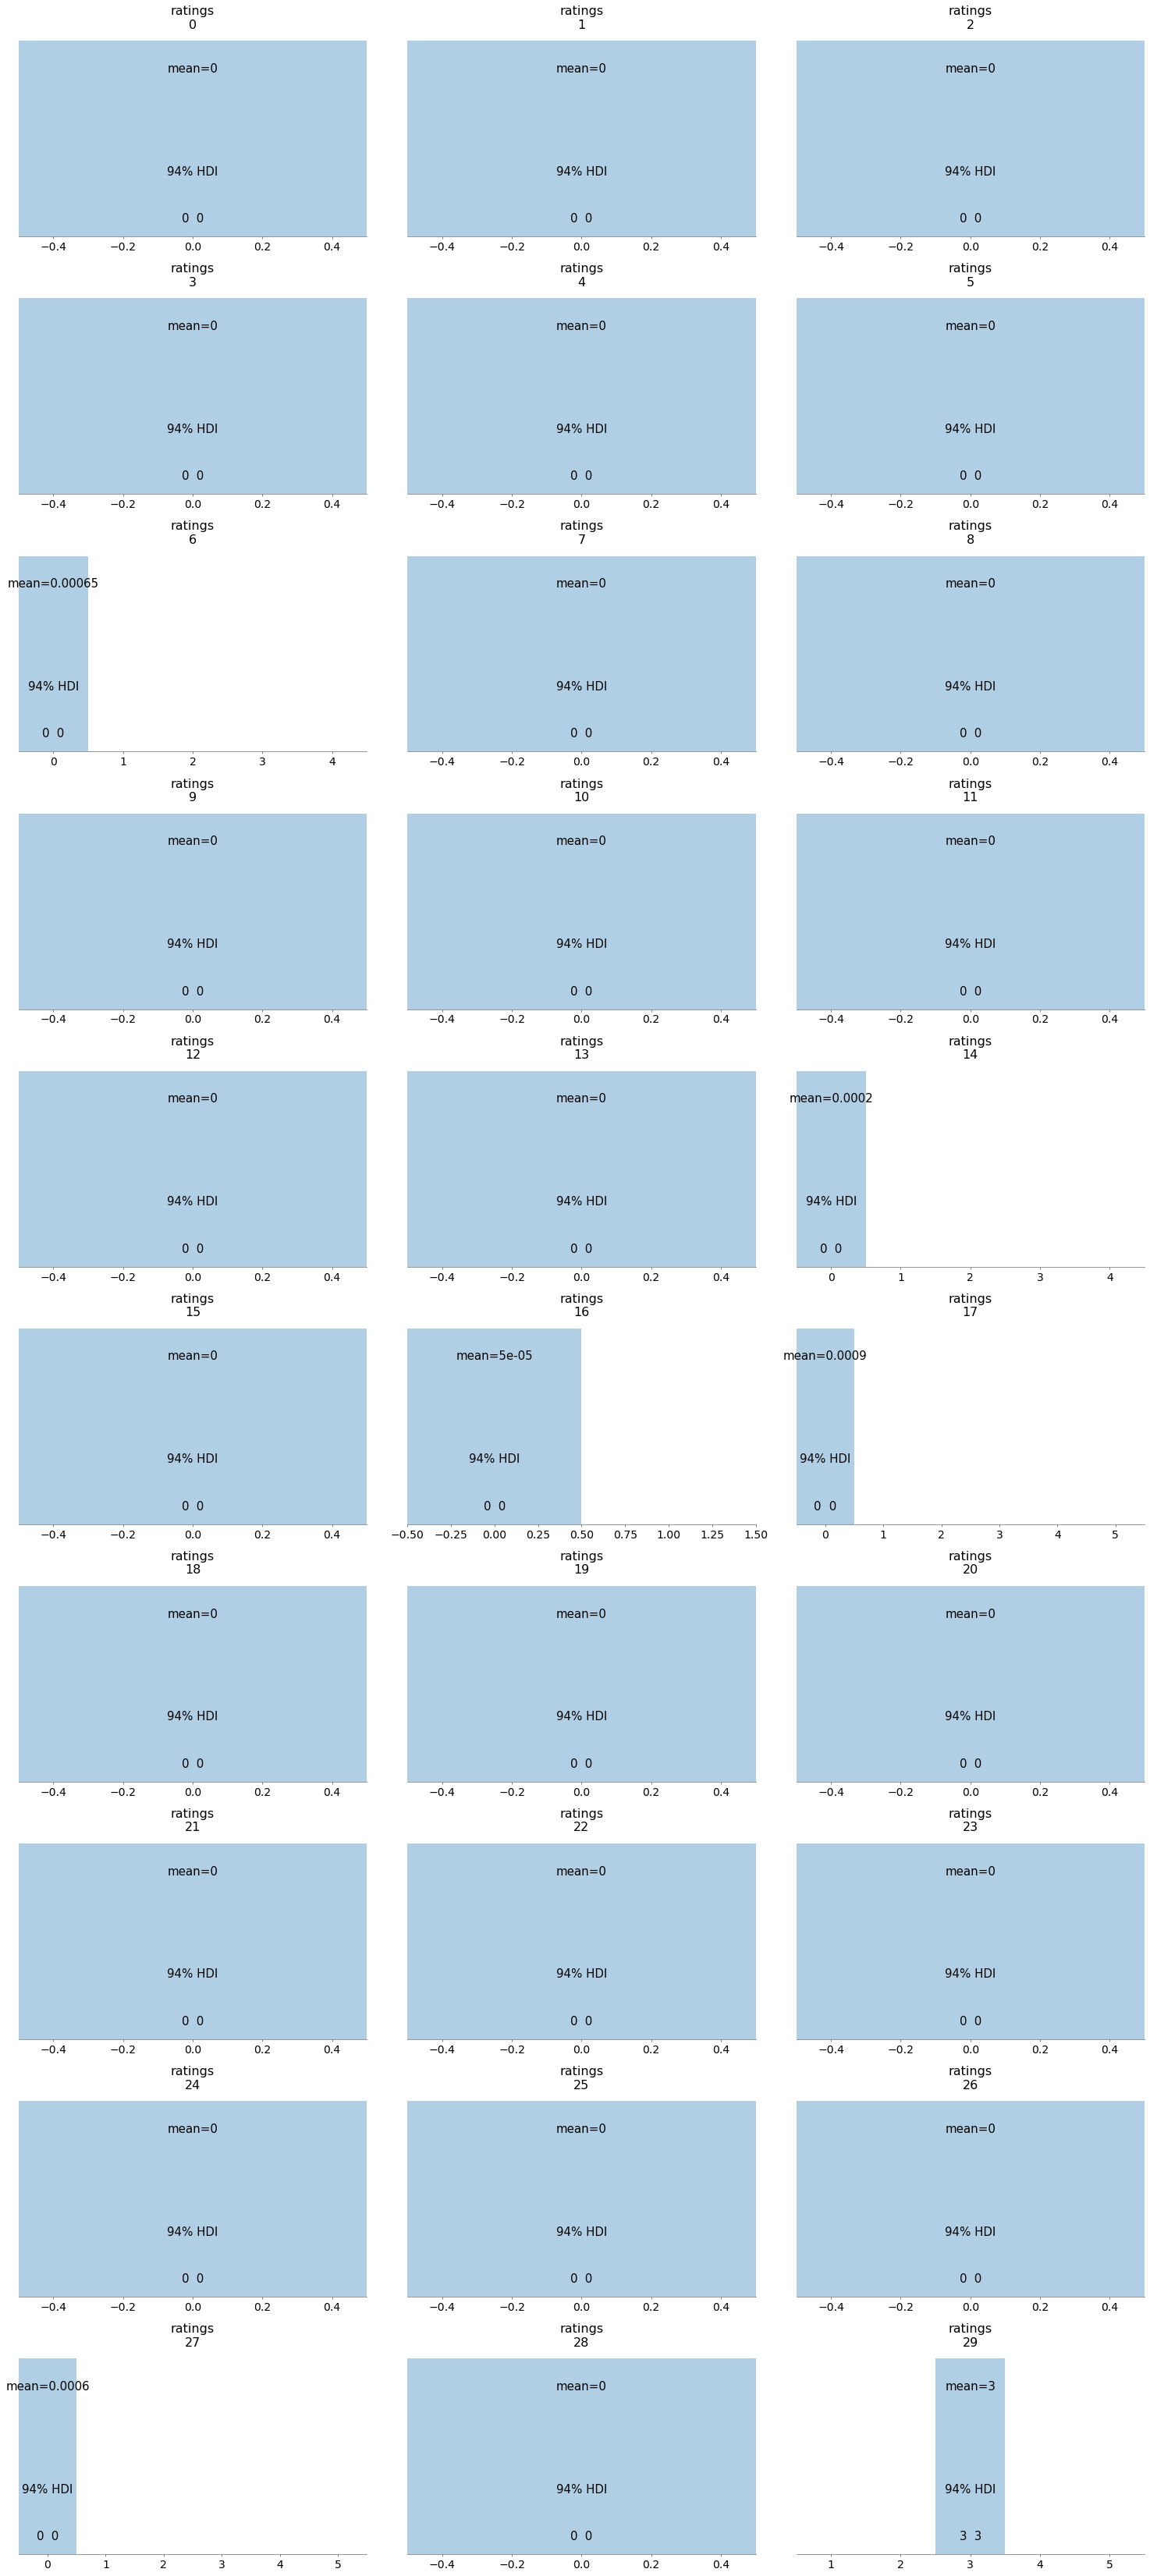

In [10]:
az.plot_posterior(trace,var_names=['ratings']);
# trace.posterior['ratings'].values.reshape(-1,30)[:,29])

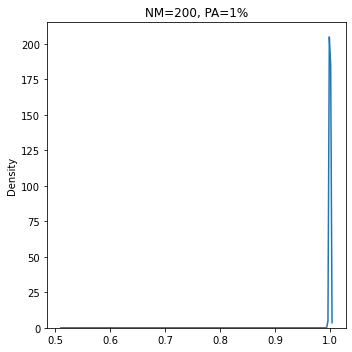

In [11]:
from numpy.linalg import norm
import seaborn as sns

def cos_sim(a, b):
    return np.dot(a, b)/(norm(a)*norm(b))

def plot_sim(trace, ax, title):
    nmovies = trace.posterior["ratings"].values.shape[-1]
    posterior = trace.posterior["ratings"].values.reshape([-1, nmovies])
    similarity = list(map(lambda b: cos_sim(obs[:nmovies], b), posterior))
    ax.set_title(title)
    sns.kdeplot(similarity, ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_sim(trace, ax, "NM=200, PA=1%")